# VGG-Face for Girl-Ladyboy Detection

We perform transfer learning using the pre-trained [VGG-Face model](http://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/parkhi15.pdf) to classify girls and ladyboys of East Asian origins, with a lot of hints on the implementation side from [@m.zaradzki](aboveintelligent.com/face-recognition-with-keras-and-opencv-2baf2a83b799) from [Above Intelligence](https://aboveintelligent.com).

In [1]:
#image stuff
import cv2
from PIL import Image
from scipy import ndimage
from scipy.io import loadmat

#the usual data science stuff
from utils import *
import os,sys
from glob import glob
from shutil import copyfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

#keras
from keras import backend as K
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Input, Conv2D, ZeroPadding2D, MaxPooling2D
from keras.layers import Flatten, Dense, Dropout,Activation, BatchNormalization
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam

#paths
data_path = '/home/charin.polpanumas/ladybug/data/processed/'
girl_path = data_path+'girl/'
ladyboy_path = data_path+'ladyboy/'
#train/valid
train_path = data_path+'train/'
train_girl = train_path+'girl/'
train_ladyboy = train_path+'ladyboy/'

valid_path = data_path+'valid/'
valid_girl = valid_path+'girl/'
valid_ladyboy = valid_path+'ladyboy/'

test_path = data_path+'test/'
test_girl = test_path+'girl/'
test_ladyboy = test_path+'ladyboy/'
#final
weight_path = data_path+'weight/'

Using TensorFlow backend.


## Data
We randomly divide the pictures into train, validation and test set at 70:20:10 ratio. This resulted in the following sets:
* Train: 3,151 girls / 2,210 ladyboys
* Valid: 900 girls / 631 ladyboys
* Test: 450 girls / 316 ladyboys

In [ ]:
#make train/validation
#inTrain = 0.7
#inValid = 0.9 
#shuffle  
#g_girl = glob(girl_path+'*.jpg')
#shuf_girl = np.random.permutation(g_girl)  
#g_ladyboy = glob(ladyboy_path+'*.jpg')
#shuf_ladyboy = np.random.permutation(g_ladyboy) 
#nb in train sets
#nb_train_girl = round(inTrain * len(shuf_girl))
#nb_train_ladyboy = round(inTrain * len(shuf_ladyboy))
#nb_valid_girl = round(inValid * len(shuf_girl))
#nb_valid_ladyboy = round(inValid * len(shuf_ladyboy))

#copy files
#for i in range(0,nb_train_girl): 
#    copyfile(shuf_girl[i], train_girl + str.split(shuf_girl[i],'/')[-1])
#for i in range(0,nb_train_ladyboy): 
#    copyfile(shuf_ladyboy[i], train_ladyboy + str.split(shuf_ladyboy[i],'/')[-1])
#for i in range(nb_train_girl,nb_valid_girl): 
#    copyfile(shuf_girl[i], valid_girl + str.split(shuf_girl[i],'/')[-1])
#for i in range(nb_train_ladyboy,nb_valid_ladyboy): 
#    copyfile(shuf_ladyboy[i], valid_ladyboy + str.split(shuf_ladyboy[i],'/')[-1])
#for i in range(nb_valid_girl,len(shuf_girl)): 
#    copyfile(shuf_girl[i], test_girl + str.split(shuf_girl[i],'/')[-1])
#for i in range(nb_valid_ladyboy,len(shuf_ladyboy)): 
#    copyfile(shuf_ladyboy[i], test_ladyboy + str.split(shuf_ladyboy[i],'/')[-1])

## Model Architecture
We use the VGG-Face architecture and load the weights from [MatCovNet](http://www.vlfeat.org/matconvnet/models/vgg-face.mat). This allows us to predict a face as one of the 2,622 faces trained by VGG-Face.

In [2]:
model = vgg_face()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

### Load Weights

In [3]:
#Adapted from https://github.com/mzaradzki/neuralnets/tree/master/vgg_faces_keras
data = loadmat('vgg-face.mat', matlab_compatible=False, struct_as_record=False)
l = data['layers']
description = data['meta'][0,0].classes[0,0].description

copy_mat_to_keras(model,l,noTop=False)

conv1_1 conv
(3, 3, 3, 64) (64, 1)
(3, 3, 3, 64) (64,)
------------------------------------------
conv1_2 conv
(3, 3, 64, 64) (64, 1)
(3, 3, 64, 64) (64,)
------------------------------------------
conv2_1 conv
(3, 3, 64, 128) (128, 1)
(3, 3, 64, 128) (128,)
------------------------------------------
conv2_2 conv
(3, 3, 128, 128) (128, 1)
(3, 3, 128, 128) (128,)
------------------------------------------
conv3_1 conv
(3, 3, 128, 256) (256, 1)
(3, 3, 128, 256) (256,)
------------------------------------------
conv3_2 conv
(3, 3, 256, 256) (256, 1)
(3, 3, 256, 256) (256,)
------------------------------------------
conv3_3 conv
(3, 3, 256, 256) (256, 1)
(3, 3, 256, 256) (256,)
------------------------------------------
conv4_1 conv
(3, 3, 256, 512) (512, 1)
(3, 3, 256, 512) (512,)
------------------------------------------
conv4_2 conv
(3, 3, 512, 512) (512, 1)
(3, 3, 512, 512) (512,)
------------------------------------------
conv4_3 conv
(3, 3, 512, 512) (512, 1)
(3, 3, 512, 512) (512,)

### Predict Faces Used to Train VGG-Face

(647, 'Ellen_Wong', 0.40613446)

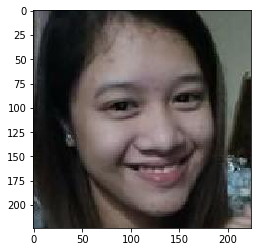

In [4]:
im = Image.open(girl_path+'5998570_gallery_636380056003535015.jpg')
plt.imshow(np.asarray(im))
predict_face(im,model,description)

## Finetuning for Girl-Ladyboy Detection
We replace the last 3 fully connected layers by two Dense-BatchNormalization-Dropout blocks and a final softmax layer with 2 classes. Then, we trained only those layers based on our train and validation sets.

In [5]:
#Create and load the model
model = vgg_face()
copy_mat_to_keras(model,l,noTop=True)

conv1_1 conv
(3, 3, 3, 64) (64, 1)
(3, 3, 3, 64) (64,)
------------------------------------------
conv1_2 conv
(3, 3, 64, 64) (64, 1)
(3, 3, 64, 64) (64,)
------------------------------------------
conv2_1 conv
(3, 3, 64, 128) (128, 1)
(3, 3, 64, 128) (128,)
------------------------------------------
conv2_2 conv
(3, 3, 128, 128) (128, 1)
(3, 3, 128, 128) (128,)
------------------------------------------
conv3_1 conv
(3, 3, 128, 256) (256, 1)
(3, 3, 128, 256) (256,)
------------------------------------------
conv3_2 conv
(3, 3, 256, 256) (256, 1)
(3, 3, 256, 256) (256,)
------------------------------------------
conv3_3 conv
(3, 3, 256, 256) (256, 1)
(3, 3, 256, 256) (256,)
------------------------------------------
conv4_1 conv
(3, 3, 256, 512) (512, 1)
(3, 3, 256, 512) (512,)
------------------------------------------
conv4_2 conv
(3, 3, 512, 512) (512, 1)
(3, 3, 512, 512) (512,)
------------------------------------------
conv4_3 conv
(3, 3, 512, 512) (512, 1)
(3, 3, 512, 512) (512,)

In [6]:
#finetuning
last_layer = model.get_layer('pool5').output
nb_class = 2
fc_dim = 512
do_p = 0.5

x = Flatten(name='flatten')(last_layer)
x = Dense(fc_dim, activation='relu', name='fc6')(x)
x = BatchNormalization(name='fc6_bn')(x)
x = Dropout(do_p)(x)
x = Dense(fc_dim,activation='relu', name='fc7')(x)
x = BatchNormalization(name='fc7_bn')(x)
x = Dropout(do_p)(x)
out = Dense(nb_class, activation='softmax', name='fc8')(x)
custom_model = Model(model.input, out)

#make all convolutions untrainable
for i in range(len(custom_model.layers)-7):
    custom_model.layers[i].trainable = False
    
#for i in range(len(custom_model.layers)):
#    print(custom_model.layers[i],custom_model.layers[i].trainable)

## Train Model
The custom model is trained using image augmentation. Note that the training accuracy is calculated as average of batches thus are lower in the beginning and higher in the later batches. This and the fact that we are using Dropout layers made the training accuracy lower than the validation accuracy, which we use to evaluate the model. 

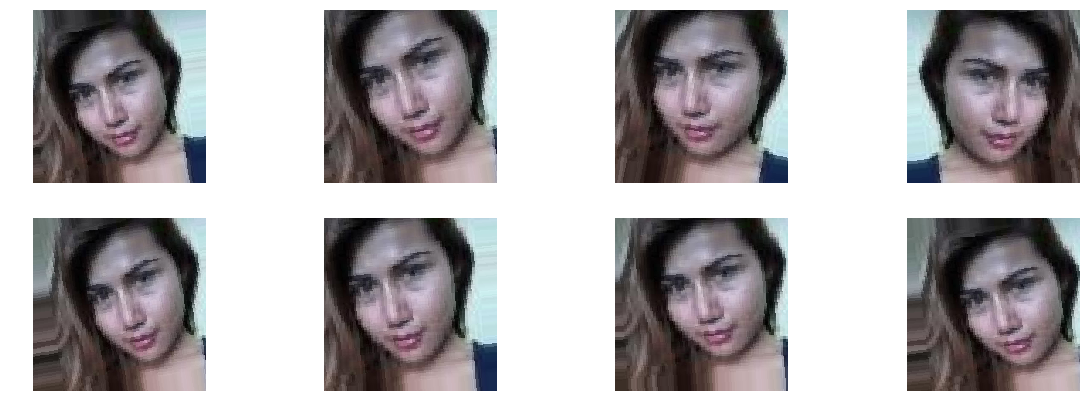

In [7]:
#image augmentation
aug_gen = image.ImageDataGenerator(rotation_range=15, width_shift_range=0.1, 
                               height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True,
                               data_format='channels_last')
img = np.expand_dims(ndimage.imread(train_ladyboy+'jid90325.jpg'),0)
aug_iter = aug_gen.flow(img)
aug_imgs = [next(aug_iter)[0].astype(np.uint8) for i in range(8)]
plots(aug_imgs, (20,7), 2)

In [8]:
#batches and labelling
batch_size = 32
train_batches = get_batches(train_path, gen=aug_gen, batch_size = batch_size)
valid_batches = get_batches(valid_path, gen=aug_gen, batch_size = batch_size)
test_batches = get_batches(test_path, gen=image.ImageDataGenerator(), batch_size = batch_size,
                          shuffle = False,class_mode=None)

valid_classes = valid_batches.classes
train_classes = train_batches.classes
test_classes = test_batches.classes

valid_labels = to_categorical(valid_classes)
train_labels = to_categorical(train_classes)
test_labels = to_categorical(test_classes)

Found 5361 images belonging to 2 classes.
Found 1531 images belonging to 2 classes.
Found 766 images belonging to 2 classes.


In [9]:
#train
custom_model.compile(optimizer=Adam(lr=0.0001), 
                     loss='categorical_crossentropy', metrics=['acc'])
hist = custom_model.fit_generator(train_batches, steps_per_epoch=train_batches.n/batch_size,  
                    validation_data=valid_batches, validation_steps=valid_batches.n/batch_size,
                    epochs=10,verbose=1)

Epoch 1/10
168/167 [==============================] - 126s - loss: 0.5236 - acc: 0.8085 - val_loss: 0.4842 - val_acc: 0.8334
Epoch 2/10
168/167 [==============================] - 118s - loss: 0.3386 - acc: 0.8796 - val_loss: 0.2731 - val_acc: 0.8948
Epoch 3/10
168/167 [==============================] - 118s - loss: 0.2860 - acc: 0.8983 - val_loss: 0.2428 - val_acc: 0.9125
Epoch 4/10
168/167 [==============================] - 118s - loss: 0.2831 - acc: 0.9009 - val_loss: 0.2423 - val_acc: 0.9138
Epoch 5/10
168/167 [==============================] - 118s - loss: 0.2646 - acc: 0.9082 - val_loss: 0.2228 - val_acc: 0.9242
Epoch 6/10
168/167 [==============================] - 118s - loss: 0.2457 - acc: 0.9118 - val_loss: 0.2042 - val_acc: 0.9268
Epoch 7/10
168/167 [==============================] - 118s - loss: 0.2211 - acc: 0.9216 - val_loss: 0.2555 - val_acc: 0.9125
Epoch 8/10
168/167 [==============================] - 118s - loss: 0.2427 - acc: 0.9135 - val_loss: 0.2096 - val_acc: 0.9229


In [10]:
#save weights
custom_model.save_weights(weight_path+'custom_model.h5')

## Test Model
We then use the test set to evaluate the final performance of the model.

### Evaluation Metrics

[[439  11]
 [ 34 282]]


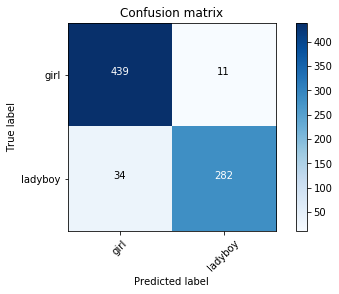

In [11]:
label_name = ['girl','ladyboy']
pred = custom_model.predict_generator(test_batches,steps=test_batches.n/batch_size)
pred_0 = pred[:,0]
pred_label = np.round(1-pred_0)
cm = confusion_matrix(test_batches.classes, pred_label)
plot_confusion_matrix(cm, test_batches.class_indices)

In [12]:
print('Accuracy: {}%'.format(round(100*accuracy_score(test_batches.classes, pred_label),2)))
print('Area Under Curve: {}'.format(round(roc_auc_score(test_batches.classes, pred_label),3)))
print(classification_report(test_batches.classes, pred_label,target_names=label_name))

Accuracy: 94.13%
Area Under Curve: 0.934
             precision    recall  f1-score   support

       girl       0.93      0.98      0.95       450
    ladyboy       0.96      0.89      0.93       316

avg / total       0.94      0.94      0.94       766



### Sample Pictures

We plotted some useful variations of predicted test pictures as guidelined by [Practical Deep Learning For Coders, Part 1](http://course.fast.ai).

(1, 'ladyboy', 0.98665011)

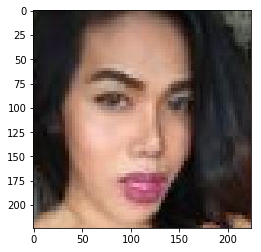

In [13]:
#test predicting ladyboy
im = Image.open(test_ladyboy+'eri41351.jpg')
plt.imshow(np.asarray(im))
predict_gender(im,custom_model,label_name)

(0, 'girl', 0.99887794)

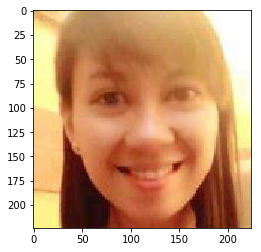

In [14]:
#test predicting girl
im = Image.open(test_girl+'6064865_gallery_636392785135430350.jpg')
plt.imshow(np.asarray(im))
predict_gender(im,custom_model,label_name)

#### Correctly Labelled

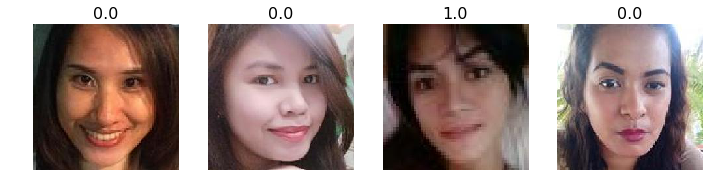

In [15]:
n_view = 4

correct = np.where(pred_label==test_batches.classes)[0]
idx = np.random.permutation(correct)[:n_view]
plots([image.load_img(test_path + test_batches.filenames[i]) for i in idx],
      titles=pred_label[idx])

#### Incorrectly Labelled

Found 45 incorrect labels


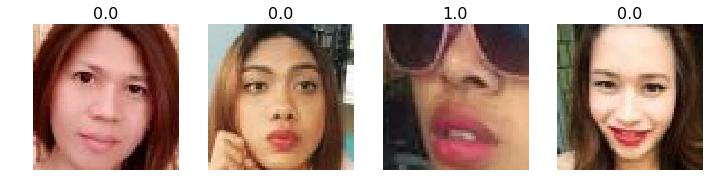

In [16]:
incorrect = np.where(pred_label!=test_batches.classes)[0]
print("Found {} incorrect labels".format(len(incorrect)))
idx = np.random.permutation(incorrect)[:n_view]
plots([image.load_img(test_path + test_batches.filenames[i]) for i in idx],
      titles=pred_label[idx])

#### Most Confident and Correct Girls

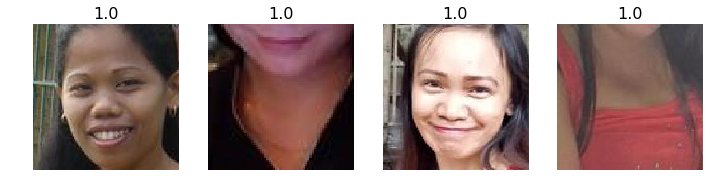

In [17]:
correct_girls = np.where((pred_label==0) & (pred_label==test_batches.classes))[0]
most_correct_girls = np.argsort(pred_0[correct_girls])[::-1][:n_view]
idx = correct_girls[most_correct_girls]
plots([image.load_img(test_path + test_batches.filenames[i]) for i in idx],
      titles=pred[correct_girls][most_correct_girls][:,0])

#### Most Confident and Correct Ladyboys

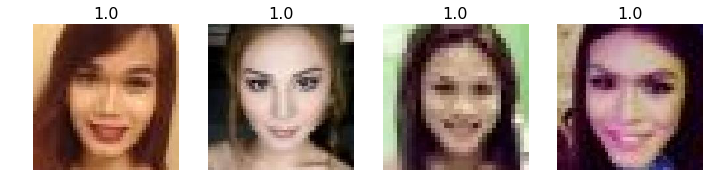

In [18]:
correct_ladyboys = np.where((pred_label==1) & (pred_label==test_batches.classes))[0]
most_correct_ladyboys = np.argsort(pred_0[correct_ladyboys])[:n_view]
idx = correct_ladyboys[most_correct_ladyboys]
plots([image.load_img(test_path + test_batches.filenames[i]) for i in idx],
      titles=pred[correct_ladyboys][most_correct_ladyboys][:,1])

#### Most Confident Are Girls But Actually Ladyboys

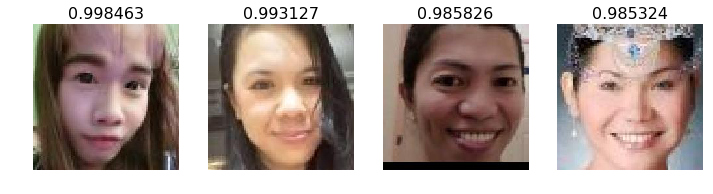

In [19]:
correct_girls = np.where((pred_label==0) & (pred_label!=test_batches.classes))[0]
most_correct_girls = np.argsort(pred_0[correct_girls])[::-1][:n_view]
idx = correct_girls[most_correct_girls]
plots([image.load_img(test_path + test_batches.filenames[i]) for i in idx],
      titles=pred[correct_girls][most_correct_girls][:,0])

#### Most Confident Are Ladyboys But Actually Girls

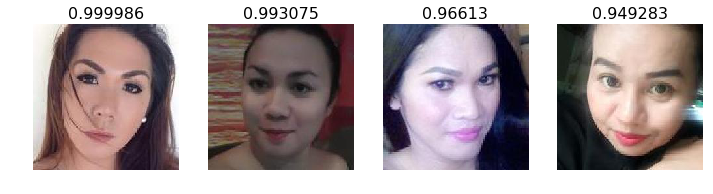

In [20]:
correct_ladyboys = np.where((pred_label==1) & (pred_label!=test_batches.classes))[0]
most_correct_ladyboys = np.argsort(pred_0[correct_ladyboys])[:n_view]
idx = correct_ladyboys[most_correct_ladyboys]
plots([image.load_img(test_path + test_batches.filenames[i]) for i in idx],
      titles=pred[correct_ladyboys][most_correct_ladyboys][:,1])

#### Most Ambiguous

They are actually ['ladyboy', 'ladyboy', 'ladyboy', 'ladyboy']


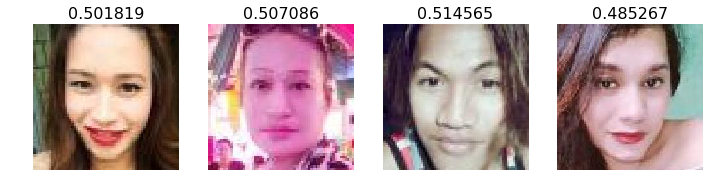

In [22]:
most_uncertain = np.argsort(np.abs(pred_0-0.5))
idx = most_uncertain[:n_view]
plots([image.load_img(test_path + test_batches.filenames[i]) for i in idx],
     titles=pred_0[most_uncertain])
print('They are actually {}'.format([label_name[i] for i in test_batches.classes[idx]]))

## References
* Deep face recognition, O. M. Parkhi and A. Vedaldi and A. Zisserman, Proceedings of the British Machine Vision Conference (BMVC), 2015 [paper](http://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/parkhi15.pdf).
* Zaradzki, M. “Face Recognition with Keras and OpenCV – Above Intelligent (AI).” Above Intelligent (AI), Above Intelligent (AI), 6 Mar. 2017, [Medium post](aboveintelligent.com/face-recognition-with-keras-and-opencv-2baf2a83b799)
* [Practical Deep Learning For Coders, Part 1](http://course.fast.ai)